In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Update dataset paths
DATASET_PATH = "PlantDoc-Dataset"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

# Load dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=(224, 224), batch_size=32
)
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=(224, 224), batch_size=32
)

# Extract class names
class_names = train_data.class_names
num_classes = len(class_names)

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


Found 1183 files belonging to 27 classes.
Found 236 files belonging to 27 classes.


In [3]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [4]:
# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [5]:

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419,006 (16.86 MB)

 Trainable params: 366,875 (1.40 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [7]:

# Train Model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[early_stop])


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.0902 - loss: 3.6189 - val_accuracy: 0.2669 - val_loss: 2.8068
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3420 - loss: 2.2929 - val_accuracy: 0.3347 - val_loss: 2.4558
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4422 - loss: 1.8714 - val_accuracy: 0.4025 - val_loss: 2.1526
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5327 - loss: 1.5192 - val_accuracy: 0.4025 - val_loss: 1.9361
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5899 - loss: 1.3539 - val_accuracy: 0.4449 - val_loss: 1.8117
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6273 - loss: 1.1675 - val_accuracy: 0.4449 - val_loss: 1.6378
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6963 - loss: 0.9384 - val_accuracy: 0.4576 - val_loss: 1.6054
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7224 - loss: 0.8144 - val_accuracy: 0.5169 - val_loss:

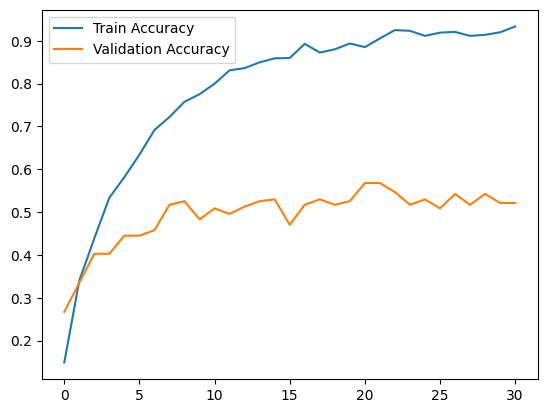

In [8]:
# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save Model
model.save("plant_disease_model.h5")

In [18]:
# Prediction Function
def predict_image(img_path, model, class_names):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_idx = np.argmax(prediction)

    return class_names[class_idx]

In [19]:
# Example
img_path = "C:/Users/PMLS/Desktop/Projects/data science/dj-dl-plant/PlantDoc-Dataset/train/Peach leaf/1U1Zf1Wk.jpg"
predicted_class = predict_image(img_path, model, class_names)
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Class: Corn rust leaf
